# **NLP project. Fake News detection** 

## **Basic imports** ##

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import common as cm
import torch

from transformers import DistilBertTokenizer
from transformers import DistilBertModel

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
import nltk
import re
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download('averaged_perceptron_tagger_eng')
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package wordnet to /Users/Kuba/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Kuba/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Kuba/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/Kuba/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/Kuba/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


## **Loading datasets** ##

In [3]:
true = cm.load_data("True.csv")
true_short = cm.choose_random_part(true, 1000)
X_train_true, X_test_true, y_train_true, y_test_true = cm.divide_data_into_train_and_test(true_short, 0.2)

fake = cm.load_data("Fake.csv")
fake_short = cm.choose_random_part(fake, 1000)
X_train_fake, X_test_fake, y_train_fake, y_test_fake = cm.divide_data_into_train_and_test(fake_short, 0.2)

In [4]:
X_train = cm.merge_datasets(X_train_true, X_train_fake)
X_test = cm.merge_datasets(X_test_true, X_test_fake)
y_train = cm.merge_datasets(y_train_true, y_train_fake)
y_test = cm.merge_datasets(y_test_true, y_test_fake)

In [5]:
X_train, y_train = cm.shuffle_respectively(X_train, y_train)
X_test, y_test = cm.shuffle_respectively(X_test, y_test)

## **Preprocessing datasets** ##

Apart from clean_data() function that we defined in common.py, we have 3 methods of preprocessing the data:

1. Generate contextual word embeddings

2. Generate static word embeddings

3. Use lemmatization, stemmatization and create TF-IDF vector

Each of the above methods will be tested on several models and we can compare which model works the best on which type of preprocessing

In [6]:
def load_embeddings(path):
    mapping = dict()

    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            line = line.strip()
            if len(line) == 0:
                continue
            splitted = line.split(" ")
            mapping[splitted[0]] = np.array(splitted[1:], dtype=float)
    return mapping

def avg_document(doc, embeddings):
        avg_emb = np.zeros_like(embeddings['italy'])
        tokens = word_tokenize(doc)
        len = 0
        for token in tokens:
            if token in embeddings.keys():
                avg_emb += embeddings[token]
                len+=1
        if len == 0:
            print('No word in glove embeddings for some article!')
            return avg_emb
        return avg_emb/len

mapping = load_embeddings('glove.6B.50d.txt') # load embeddings into a dict mapping words into vectors

In [7]:
# Generate contextual word embeddings
def create_contextual_embeddings(X: pd.DataFrame) -> np.array:
    """
        Function that creates contextual word embeddings from input data using DistilBERT model
        :param X: ...
        :return: ...
    """
    # Loading DistilBERT model and tokenizer
    model_class, tokenizer_class, pretrained_weights = (DistilBertModel, DistilBertTokenizer, 'distilbert-base-uncased')
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)

    # Tokenizing
    max_len = 512
    X['text'] = X['text'].apply((lambda x: x[:max_len]))
    tokenized = X['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

    # Padding
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

    # Masking
    attention_mask = np.where(padded != 0, 1, 0)

    # Running sentences through BERT
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)

    # Output of DistilBERT will be input for Logistic Regression
    features = last_hidden_states[0][:,0,:].numpy()

    return features

def create_static_embeddings(X, embeddings):
    return [avg_document(doc, embeddings) for doc in X]

def create_TF_IDF(X):
    # TODO
    return

In [8]:
X_train_pre, y_train_pre = cm.clean_data(X_train, y_train)
X_test_pre, y_test_pre = cm.clean_data(X_test, y_test)

## **Necessary imports** ##

In [45]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score

In [46]:
def display_metrics(model, y_test, y_pred):
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F1 score: {f1_score(y_test, y_pred)}")
    print()
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels = model.classes_), display_labels=model.classes_)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

In [11]:
# def classify_and_report(classifier):
#     # ------------------- CLASSIFY -----------
#     classifier.fit(train_transformed, y_train_pre['target'])

#     # ------------------- EVALUATE -----------
#     accuracy = classifier.score(test_transformed, y_test_pre)
#     print("Accuracy: {n}%".format(
#         n=100.*accuracy))
#     print(classification_report(y_test_pre, classifier.predict(test_transformed)))

## **Aproach 1 - Contextual Word Embeddings** ##

In [12]:
X_train_contextual = create_contextual_embeddings(X_train_pre)
X_test_contextual = create_contextual_embeddings(X_test_pre)

### **Model 1 - SVM** ##

In [47]:
svm = SVC()
svm.fit(X_train_contextual, y_train_pre)

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

Accuracy: 0.9225
F1 score: 0.9238329238329238

Recall: 0.94
Precision: 0.9082125603864735


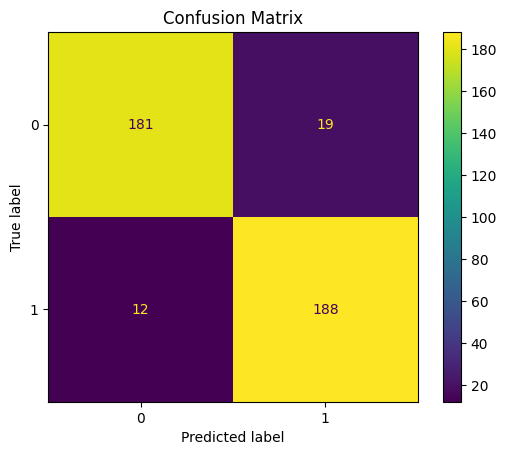

In [48]:
pred_svm_contextual = svm.predict(X_test_contextual)
display_metrics(svm, y_test_pre, pred_svm_contextual)

### **Model 2 - Logistic Regression**

In [49]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train_contextual, y_train_pre)

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

Accuracy: 0.9475
F1 score: 0.9478908188585607

Recall: 0.955
Precision: 0.9408866995073891


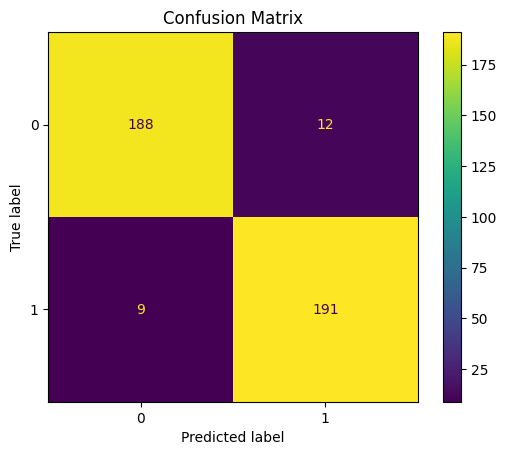

In [50]:
pred_lr_contextual = lr_clf.predict(X_test_contextual)
display_metrics(lr_clf, y_test_pre, pred_lr_contextual)

### **Model 3 - kNN**

In [51]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_contextual, y_train_pre)

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=10)

Accuracy: 0.915
F1 score: 0.9141414141414141

Recall: 0.905
Precision: 0.923469387755102


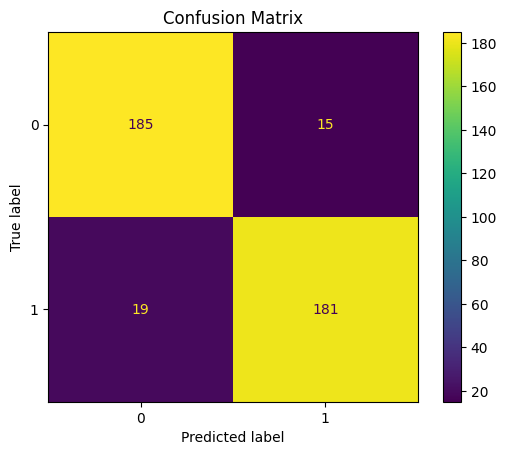

In [52]:
pred_knn_contextual = knn.predict(X_test_contextual)
display_metrics(knn, y_test_pre, pred_knn_contextual)

### **Model 4 - Decision Tree** ##

In [53]:
tree_clf = DecisionTreeClassifier(criterion="entropy")
tree_clf.fit(X_train_contextual, y_train_pre)

DecisionTreeClassifier(criterion='entropy')

Accuracy: 0.8125
F1 score: 0.8138957816377171

Recall: 0.82
Precision: 0.8078817733990148


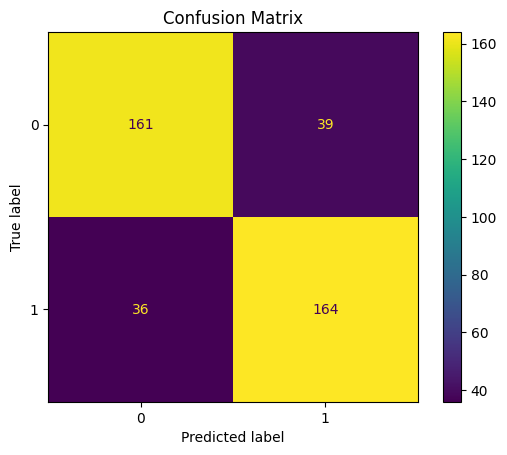

In [54]:
pred_dt_contextual = tree_clf.predict(X_test_contextual)
display_metrics(tree_clf, y_test_pre, pred_dt_contextual)

### **Model 5 - Random Forests** ##

In [55]:
rf = RandomForestClassifier()
rf.fit(X_train_contextual, y_train_pre)

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

Accuracy: 0.8975
F1 score: 0.8992628992628993

Recall: 0.915
Precision: 0.8840579710144928


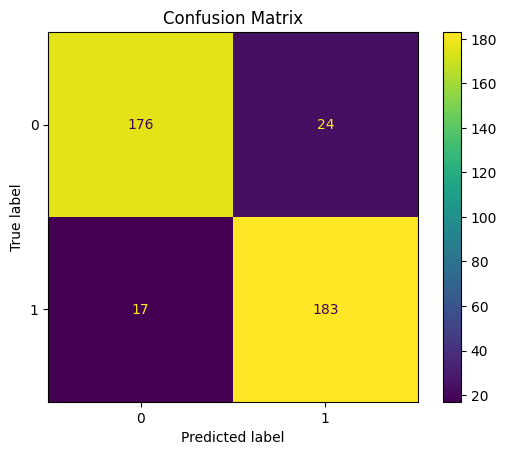

In [56]:
pred_rf_contextual = rf.predict(X_test_contextual)
display_metrics(rf, y_test_pre, pred_rf_contextual)

### **Model 6 - Neural Network**

In [57]:
...

Ellipsis

## **Approach 2 - Static Word Embeddings** ##

In [58]:
X_train_static = create_static_embeddings(X_train_pre['text'], mapping)
X_test_static = create_static_embeddings(X_test_pre['text'], mapping)

No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for so

### **Model 1 - SVM** ##

In [59]:
svm = SVC()
svm.fit(X_train_static, y_train_pre)

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

Accuracy: 0.88
F1 score: 0.8787878787878788

Recall: 0.87
Precision: 0.8877551020408163


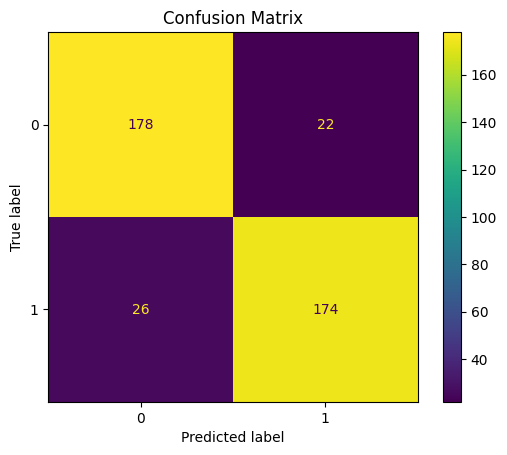

In [60]:
pred_svm_static = svm.predict(X_test_static)
# print(classification_report(y_test_pre, pred))
display_metrics(svm, y_test_pre, pred_svm_static)

### **Model 2 - Logistic Regression**

In [61]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train_static, y_train_pre)

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

Accuracy: 0.8825
F1 score: 0.8833746898263027

Recall: 0.89
Precision: 0.8768472906403941


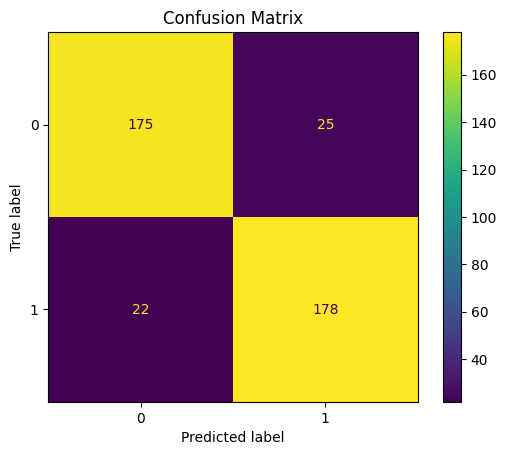

In [62]:
pred_lr_static = lr_clf.predict(X_test_static)
display_metrics(lr_clf, y_test_pre, pred_lr_static)

### **Model 3 - kNN**

In [63]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_static, y_train_pre)

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=10)

Accuracy: 0.895
F1 score: 0.8917525773195877

Recall: 0.865
Precision: 0.9202127659574468


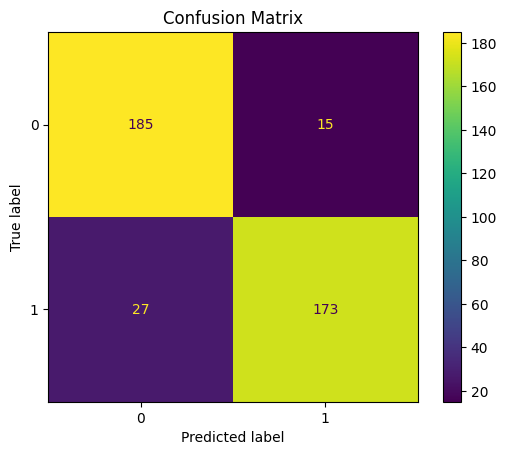

In [64]:
pred_knn_static = knn.predict(X_test_static)
display_metrics(knn, y_test_pre, pred_knn_static)

### **Model 4 - Decision Tree**

In [65]:
tree_clf = DecisionTreeClassifier(criterion="entropy")
tree_clf.fit(X_train_static, y_train_pre)

DecisionTreeClassifier(criterion='entropy')

Accuracy: 0.805
F1 score: 0.8020304568527918

Recall: 0.79
Precision: 0.8144329896907216


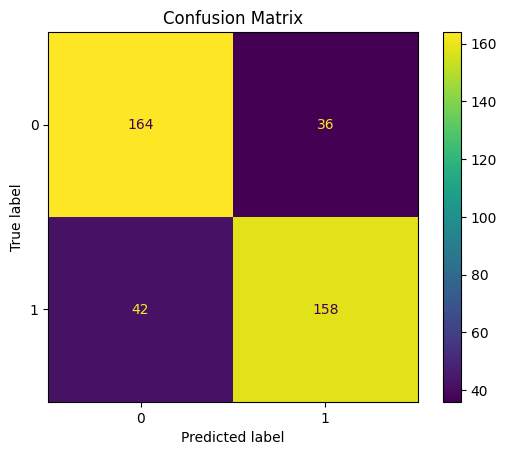

In [66]:
pred_dt_static = tree_clf.predict(X_test_static)
display_metrics(tree_clf, y_test_pre, pred_dt_static)

### **Model 5 - Random Forest**

In [67]:
rf = RandomForestClassifier()
rf.fit(X_train_static, y_train_pre)

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

Accuracy: 0.89
F1 score: 0.8905472636815921

Recall: 0.895
Precision: 0.8861386138613861


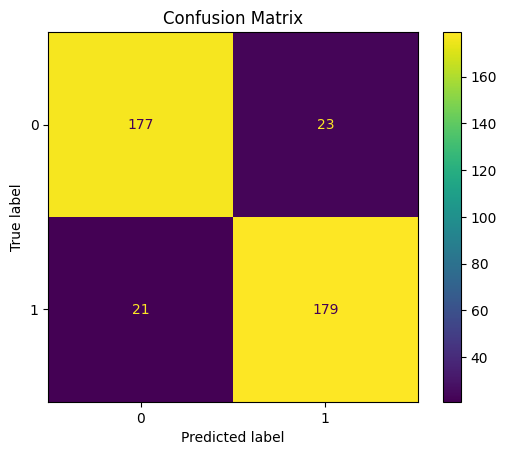

In [68]:
pred_rf_static = rf.predict(X_test_static)
display_metrics(rf, y_test_pre, pred_rf_static)

### **Model 6 - Neural Network**

In [27]:
...

Ellipsis

## **Approach 3 - TF-IDF vector** ##

## **Summary and comparison of the results** ##

In [69]:
summary = pd.DataFrame(index = ['SVM', 'Linear Regression', 'kNN', 'Decision Tree', 'Random Forest'], columns = ['static', 'contextual'])
statics = [pred_svm_static, pred_lr_static, pred_knn_static, pred_dt_static, pred_rf_static]
statics_acc = []
contextuals = [pred_svm_contextual, pred_lr_contextual, pred_knn_contextual, pred_dt_contextual, pred_rf_contextual]
contextuals_acc = []

for st in statics:
    statics_acc.append(accuracy_score(y_test_pre, st))

for ct in contextuals:
    contextuals_acc.append(accuracy_score(y_test_pre, ct))

summary.static = statics_acc
summary.contextual = contextuals_acc

summary

,static,contextual
SVM,0.8800,0.9225
Linear Regression,0.8825,0.9475
kNN,0.8950,0.9150
Decision Tree,0.8050,0.8125
Random Forest,0.8900,0.8975
